# DSO 560 Natural Language Processing Final Project

### Team members: Tanner Curley, Shao Xuan Chew, Robert Zhu

General Credits:
- Tanner contributed signficantly on ideas, slides, and visualizations
- Xuan contributed primarily on preprocessing and cleaning of the data along with code quality
- Robert focused on model building and tuning them to achieve a satisfactory performance
- Overall, everyone contributed and validated each others work throughout the project
- Specific code blocks from online soruces have been cited accordingly


In [1]:
# !python -m spacy download en_core_web_md
# %pip install -U textblob
# !python -m textblob.download_corpora

## Prep : Configurations

Adjust these parameters if needed before running.

In [2]:
# perform lemmatization (not recommended when using any pretrained embedding)
LEMMA = False

# size of the vocab for
VOCAB_SIZE = 20000

# for self attention
DATA_POINTS = 10
DIMENSIONS = 240
SEQUENCE_LENGTH = 4

# Whether to use GPU
USE_GPU = 1

In [3]:
# Just to check device data
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4167609699688724646
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7806648320
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6981054749927275659
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:07:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


## Prep : Imports

In [2]:
# Import Packages
import pandas as pd
import numpy as np 

from numpy import array, argmax, asarray, zeros
from random import randint

import re
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from textacy import preprocessing
nlp = spacy.load('en_core_web_md')

from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF

from skmultilearn.model_selection import iterative_train_test_split

from textblob import Word
from textblob import TextBlob

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Concatenate

import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Flatten, concatenate, Activation, RepeatVector, Permute
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import Flatten, Masking
from keras.layers.recurrent import SimpleRNN, LSTM
from keras import backend as K
from keras.models import Model
from keras.models import Sequential
from keras_self_attention import SeqSelfAttention

from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [6]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Loading Data

In [7]:
# Read and peek at the dataset
df = pd.read_csv('complaints_processed.csv')
df.head()


,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


In [8]:
complaint_types = list(df['product'].value_counts().index)

In [9]:
NUM_CLASSES = len(complaint_types)

## Summary statistics

In [10]:
df.shape

(162421, 3)

In [11]:
df['product'].value_counts()

credit_reporting       91179
debt_collection        23150
mortgages_and_loans    18990
credit_card            15566
retail_banking         13536
Name: product, dtype: int64

#### Note that the dataset is imbalanced

## Preprocessing :
    
1. remove hyphens and accents
2. create customized stopwords list and remove stopwords
3. regex cleaning
<!-- 4. typo correction with textblob -->

In [12]:
df['narrative'] = df['narrative'].apply(str)

In [13]:
preproc = preprocessing.make_pipeline(
    preprocessing.normalize.hyphenated_words,
    preprocessing.remove.accents,
)

### Stopwords

In [14]:
set(stopwords.words('english'))
# removing some negative words from stopwords list
nltk_stopwords = set(stopwords.words('english'))
nltk_stopwords.remove('below')
nltk_stopwords.remove("aren't")
nltk_stopwords.remove('couldn')
nltk_stopwords.remove("couldn't")
nltk_stopwords.remove("didn't")
nltk_stopwords = list(nltk_stopwords)
# add some abstract terms
nltk_stopwords.append('like')
nltk_stopwords.append('please')

nltk_stopwords = set(nltk_stopwords)

### Additional Cleaning

In [15]:
# removing all words with more than 15 digits
df['narrative'] = df['narrative'].str.replace(r'\b([a-z]|[A-Z]){15,}\b', '', case=False)

C:\Users\Robert\AppData\Local\Temp\ipykernel_6828\868481445.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['narrative'] = df['narrative'].str.replace(r'\b([a-z]|[A-Z]){15,}\b', '', case=False)


In [16]:
# removing all characters that appear more than 2 times
df['narrative'] = df['narrative'].str.replace(r'(.)\1{3,}?', '', case=False)


C:\Users\Robert\AppData\Local\Temp\ipykernel_6828\1200782744.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['narrative'] = df['narrative'].str.replace(r'(.)\1{3,}?', '', case=False)


### Spelling

In [20]:
def spelling_correction(sentence: str):
    sentence = str(sentence)
    to_ret = TextBlob(sentence)
    to_ret = str(to_ret.correct())
    return to_ret

In [21]:
# df['narrative'] = df['narrative'].apply(spelling_correction)

### Lemmatizing

In [22]:
lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(str(sentence)))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [23]:
if LEMMA:
    df['narrative'] = df['narrative'].apply(lemmatize_sentence)

In [24]:
labels = df['product']

## Model Preparation
1. tokenize
2. integer encoding
3. glove vectors
4. embedding matrix
    

In [25]:
# tokenize text
tokenizer = Tokenizer(num_words=5000, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(df['narrative'])

In [26]:
# integer encoding
def get_max_token_length_per_doc(docs: List[List[str]])-> int:
    return max(list(map(lambda x: len(x.split()), docs)))

# get the max length in terms of token length
max_length = get_max_token_length_per_doc(df['narrative'])


def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)

MAX_SEQUENCE_LENGTH = 300
# integer encode the documents
encoded_docs = integer_encode_documents(df['narrative'], tokenizer)
# this is a list of lists, the numbers represent the index position of that word.
# for instance, 33 means the 33rd word in the vocabulary
padded_docs = pad_sequences(encoded_docs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [27]:
# glove vectors
def load_glove_vectors():
    embeddings_index = {}
    with open('glove\glove.6B.100d.txt') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index


embeddings_index = load_glove_vectors()

Loaded 400000 word vectors.


In [28]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    if i >= VOCAB_SIZE:
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector

In [29]:
encoder = LabelBinarizer()
transfomed_labels = encoder.fit_transform(labels)
# print(transfomed_labels)

In [30]:
padded_docs.shape

(162421, 300)

In [31]:
X_train, y_train, X_test, y_test = iterative_train_test_split(padded_docs, transfomed_labels, test_size=0.2)

In [32]:
X_train.shape

(129937, 300)

In [33]:
y_train.shape

(129937, 5)

## Model Definitions
1. LSTM
2. Bi-directional LSTM
3. RNN
4. BERT
5. Self-Attention

In [85]:
def make_lstm_classification_model(plot=False):
    model = keras.models.Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    # model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(CuDNNLSTM(units=64, input_shape=(1, MAX_SEQUENCE_LENGTH)))
    model.add(Dense(16))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    # Compile the model
    model.compile(loss="categorical_crossentropy", optimizer= "adam", metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [86]:
model1 = make_lstm_classification_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          2000000   
_________________________________________________________________
cu_dnnlstm (CuDNNLSTM)       (None, 64)                42496     
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 85        
Total params: 2,043,621
Trainable params: 43,621
Non-trainable params: 2,000,000
_________________________________________________________________


In [87]:
def fit_model(model, gpu = USE_GPU):
    if not USE_GPU:
        with tf.device('/cpu:0'):
            history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=10, verbose=1)
    else:
            history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=10, verbose=1)
    return history

In [88]:
# fit the model
history1 = fit_model(model1, gpu=1)

Epoch 1/10
4061/4061 [==============================] - 57s 14ms/step - loss: 1.0879 - accuracy: 0.6037 - val_loss: 0.7456 - val_accuracy: 0.7224
Epoch 2/10
4061/4061 [==============================] - 57s 14ms/step - loss: 0.6024 - accuracy: 0.7804 - val_loss: 0.5363 - val_accuracy: 0.8118
Epoch 3/10
4061/4061 [==============================] - 57s 14ms/step - loss: 0.4730 - accuracy: 0.8375 - val_loss: 0.4603 - val_accuracy: 0.8424
Epoch 4/10
4061/4061 [==============================] - 57s 14ms/step - loss: 0.4217 - accuracy: 0.8581 - val_loss: 0.4507 - val_accuracy: 0.8508
Epoch 5/10
4061/4061 [==============================] - 57s 14ms/step - loss: 0.3875 - accuracy: 0.8685 - val_loss: 0.4102 - val_accuracy: 0.8616
Epoch 6/10
4061/4061 [==============================] - 57s 14ms/step - loss: 0.3561 - accuracy: 0.8776 - val_loss: 0.3917 - val_accuracy: 0.8644
Epoch 7/10
4061/4061 [==============================] - 57s 14ms/step - loss: 0.3346 - accuracy: 0.8840 - val_loss: 0.3866 -

In [83]:
K.clear_session()

In [46]:
# From https://keras.io/visualization/
def plot_performance(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# plot_performance(history)

In [39]:
def make_bi_lstm_classification_model(plot=False):
    model = keras.models.Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(SpatialDropout1D(0.2)) #spatial dropout the whole channel to increase performance and prevent overfitting
    model.add(Bidirectional(CuDNNLSTM(64, return_sequences=True)))
    model.add(Bidirectional(CuDNNLSTM(32)))
    model.add(Dropout(0.25)) #dropout to prevent overfitting
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    # Compile the model
    model.compile(loss="categorical_crossentropy", optimizer= "adam", metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [40]:
model2 = make_bi_lstm_classification_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          2000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 300, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 300, 128)          84992     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41472     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 2,126,789
Trainable params: 126,789
Non-trainable params: 2,000,000
________________________________________

In [41]:
# fit the model
history2 = fit_model(model2, gpu=0)

Epoch 1/10
4061/4061 [==============================] - 173s 42ms/step - loss: 0.5640 - accuracy: 0.8005 - val_loss: 0.4402 - val_accuracy: 0.8440
Epoch 2/10
4061/4061 [==============================] - 141s 35ms/step - loss: 0.4235 - accuracy: 0.8516 - val_loss: 0.4046 - val_accuracy: 0.8565
Epoch 3/10
4061/4061 [==============================] - 139s 34ms/step - loss: 0.3882 - accuracy: 0.8633 - val_loss: 0.3891 - val_accuracy: 0.8609
Epoch 4/10
4061/4061 [==============================] - 140s 34ms/step - loss: 0.3669 - accuracy: 0.8702 - val_loss: 0.3736 - val_accuracy: 0.8658
Epoch 5/10
4061/4061 [==============================] - 140s 35ms/step - loss: 0.3470 - accuracy: 0.8774 - val_loss: 0.3576 - val_accuracy: 0.8723
Epoch 6/10
4061/4061 [==============================] - 140s 35ms/step - loss: 0.3339 - accuracy: 0.8822 - val_loss: 0.3487 - val_accuracy: 0.8739
Epoch 7/10
4061/4061 [==============================] - 140s 35ms/step - loss: 0.3209 - accuracy: 0.8866 - val_loss: 0

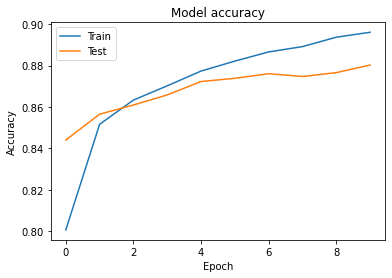

In [47]:
plot_performance(history2)

In [ ]:
K.clear_session()

In [48]:
def make_rnn_classification_model(plot=False):
    model = keras.models.Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(SimpleRNN(64))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    # Compile the model
    model.compile(loss="categorical_crossentropy", optimizer= "adam", metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [49]:
model3 = make_rnn_classification_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          2000000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                10560     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 2,010,885
Trainable params: 10,885
Non-trainable params: 2,000,000
_________________________________________________________________


In [51]:
history3 = fit_model(model3, gpu=0)

Epoch 1/10
4061/4061 [==============================] - 1334s 329ms/step - loss: 1.2837 - accuracy: 0.5615 - val_loss: 1.2763 - val_accuracy: 0.5621
Epoch 2/10
4061/4061 [==============================] - 1325s 326ms/step - loss: 1.2359 - accuracy: 0.5631 - val_loss: 1.2657 - val_accuracy: 0.5676
Epoch 3/10
4061/4061 [==============================] - 1321s 325ms/step - loss: 1.2363 - accuracy: 0.5622 - val_loss: 1.2764 - val_accuracy: 0.5623
Epoch 4/10
4061/4061 [==============================] - 1320s 325ms/step - loss: 1.2824 - accuracy: 0.5621 - val_loss: 1.2836 - val_accuracy: 0.5623
Epoch 5/10
4061/4061 [==============================] - 1315s 324ms/step - loss: 1.2817 - accuracy: 0.5626 - val_loss: 1.2775 - val_accuracy: 0.5633
Epoch 6/10
4061/4061 [==============================] - 1318s 325ms/step - loss: 1.2590 - accuracy: 0.5642 - val_loss: 1.2715 - val_accuracy: 0.5641
Epoch 7/10
4061/4061 [==============================] - 1321s 325ms/step - loss: 1.2744 - accuracy: 0.5654

In [ ]:
K.clear_session()

In [52]:
# model courtesy of Polignano et al.: https://dl.acm.org/doi/10.1145/3314183.3324983
def make_bi_lstm_self_attention_classification_model(plot=False):
    input = Input(shape=(MAX_SEQUENCE_LENGTH,))
    model = Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False) (input)
    # model = SpatialDropout1D(0.2) (model) #spatial dropout the whole channel to increase performance and prevent overfitting
    bi = Bidirectional(CuDNNLSTM(64, return_sequences=True)) (model)
    model = SeqSelfAttention(attention_activation='relu') (bi)
    model = Conv1D(128, 5, activation='relu') (model)
    model = MaxPooling1D() (model)
    model = Dropout(0.2) (model) #dropout to prevent overfitting
    model = Concatenate(axis=1)([model, bi])
    model = GlobalMaxPooling1D() (model)
    model = Dense(100, activation='softmax') (model)
    model = Dropout(0.2) (model)
    model = Dense(NUM_CLASSES, activation='softmax') (model)
    
    # Compile the model
    # model.compile(loss="categorical_crossentropy", optimizer= "adam", metrics=['accuracy'])
    m = keras.models.Model(inputs=[input], outputs=[model])
    m.compile(loss="categorical_crossentropy", optimizer= "adam", metrics=['accuracy'])
    # summarize the model
    m.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return m

In [53]:
model4 = make_bi_lstm_self_attention_classification_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 300, 100)     2000000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 300, 128)     84992       embedding_2[0][0]                
__________________________________________________________________________________________________
seq_self_attention (SeqSelfAtte (None, 300, 128)     8257        bidirectional_2[0][0]            
______________________________________________________________________________________________

In [54]:
history4 = fit_model(model4, gpu=1)

Epoch 1/10
4061/4061 [==============================] - 144s 34ms/step - loss: 1.3047 - accuracy: 0.5611 - val_loss: 1.2848 - val_accuracy: 0.5614
Epoch 2/10
4061/4061 [==============================] - 140s 34ms/step - loss: 1.2852 - accuracy: 0.5614 - val_loss: 1.2847 - val_accuracy: 0.5614
Epoch 3/10
4061/4061 [==============================] - 140s 34ms/step - loss: 1.0075 - accuracy: 0.6322 - val_loss: 0.6191 - val_accuracy: 0.8235
Epoch 4/10
4061/4061 [==============================] - 140s 34ms/step - loss: 0.5582 - accuracy: 0.8081 - val_loss: 0.4401 - val_accuracy: 0.8620
Epoch 5/10
4061/4061 [==============================] - 140s 35ms/step - loss: 0.4729 - accuracy: 0.8337 - val_loss: 0.4102 - val_accuracy: 0.8700
Epoch 6/10
4061/4061 [==============================] - 140s 34ms/step - loss: 0.4156 - accuracy: 0.8659 - val_loss: 0.3788 - val_accuracy: 0.8747
Epoch 7/10
4061/4061 [==============================] - 140s 34ms/step - loss: 0.3748 - accuracy: 0.8834 - val_loss: 0

In [ ]:
K.clear_session()

In [56]:
def create_confusion_matrix(model):
    y_pred = model.predict(X_test)
    y_classes_pred = y_pred.argmax(axis=-1)
    y_classes_true = y_test.argmax(axis=-1)
    cf_matrix = confusion_matrix(y_classes_true, y_classes_pred)
    sns.heatmap(cf_matrix, annot=True)
    return cf_matrix

## Model Evaluations/Comparisons

array([[ 2375,   376,    85,    60,   217],
       [  253, 17183,   550,   196,    54],
       [  176,  1043,  3146,   210,    55],
       [   66,   481,   110,  3085,    56],
       [  292,    51,    31,    84,  2249]], dtype=int64)

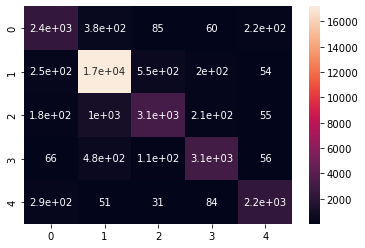

In [57]:
create_confusion_matrix(model1)

array([[ 2489,   308,    96,    41,   179],
       [  244, 17128,   611,   215,    38],
       [  126,   750,  3534,   188,    32],
       [   67,   396,   131,  3148,    56],
       [  259,    55,    39,    58,  2296]], dtype=int64)

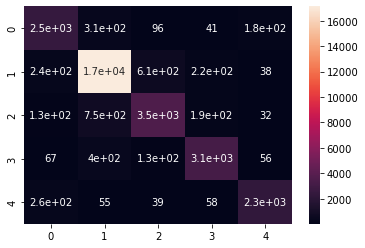

In [58]:
create_confusion_matrix(model2)

array([[   21,  3027,     5,    40,    20],
       [   13, 18161,    15,    34,    13],
       [   13,  4572,    20,    22,     3],
       [   20,  3626,    16,   122,    14],
       [   18,  2624,     6,    40,    19]], dtype=int64)

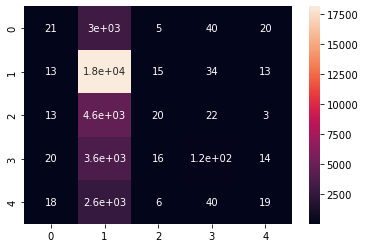

In [65]:
create_confusion_matrix(model3)

array([[ 2458,   371,    65,    13,   206],
       [  212, 17539,   330,   108,    47],
       [  166,  1131,  3142,   156,    35],
       [   94,   536,    90,  2997,    81],
       [  245,    66,    19,    37,  2340]], dtype=int64)

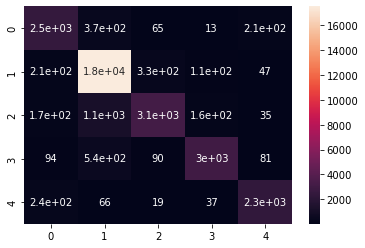

In [66]:
create_confusion_matrix(model4)

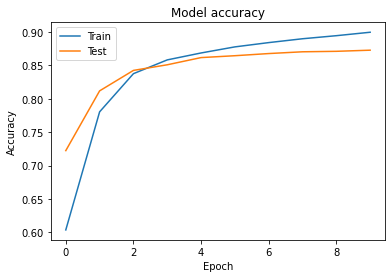

In [89]:
plot_performance(history1)

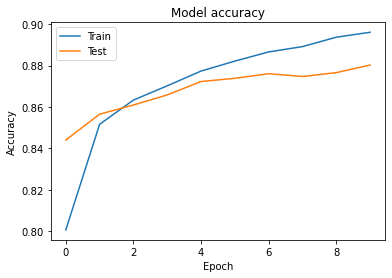

In [76]:
plot_performance(history2)

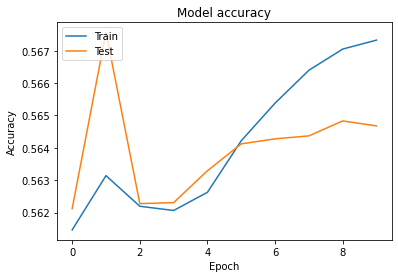

In [79]:
plot_performance(history3)

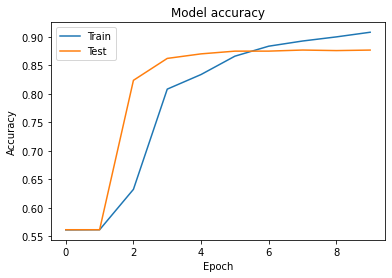

In [80]:
plot_performance(history4)